In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#from cleantext import clean

In [105]:
train_data = pd.read_csv('raw_data/train.csv', index_col='id')

In [106]:
train_data.head(3)

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [107]:
train_data.shape

(7613, 4)

In [108]:
train_data.isna().sum()/train_data.shape[0]

keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

In [109]:
list(train_data['location'].unique())

[nan,
 'Birmingham',
 'Est. September 2012 - Bristol',
 'AFRICA',
 'Philadelphia, PA',
 'London, UK',
 'Pretoria',
 'World Wide!!',
 'Paranaque City',
 'Live On Webcam',
 'milky way',
 'GREENSBORO,NORTH CAROLINA',
 'England.',
 'Sheffield Township, Ohio',
 'India',
 'Barbados',
 'Anaheim',
 'Abuja',
 'USA',
 'South Africa',
 'Sao Paulo, Brazil',
 'hollywoodland ',
 'Edmonton, Alberta - Treaty 6',
 'Inang Pamantasan',
 'Twitter Lockout in progress',
 'Concord, CA',
 'Calgary, AB',
 'San Francisco',
 'CLVLND',
 'Nashville, TN',
 'Santa Clara, CA',
 'UK',
 'St. Louis, MO',
 'Walker County, Alabama',
 'Australia',
 'North Carolina',
 'Norf Carolina',
 'San Mateo County, CA',
 'Njoro, Kenya',
 "Your Sister's Bedroom",
 'Arlington, TX',
 'South Bloomfield, OH',
 'New Hanover County, NC',
 'Maldives',
 'Manchester, NH',
 'Wilmington, NC',
 'global',
 'Alberta | Sask. | Montana',
 'Charlotte',
 'Baton Rouge, LA',
 'Hagerstown, MD',
 'Gloucestershire , UK',
 'Nairobi, Kenya',
 'Instagram - @hey

The dataset is missing ~0.8% of values in the keyword column and around 33% of values in the location column. For simplicity sake, I will drop the location column, and replace NaN in keywords with a "None" placeholder. 

In [110]:
train_data.drop(columns=['location'], inplace=True)

In [111]:
train_data['keyword'] = train_data['keyword'].replace(np.nan, 'None')

In [112]:
train_data.isna().sum()

keyword    0
text       0
target     0
dtype: int64

Let's check the distribution of targets in the dataset.

Text(0.5, 1.0, 'Target Distribution')

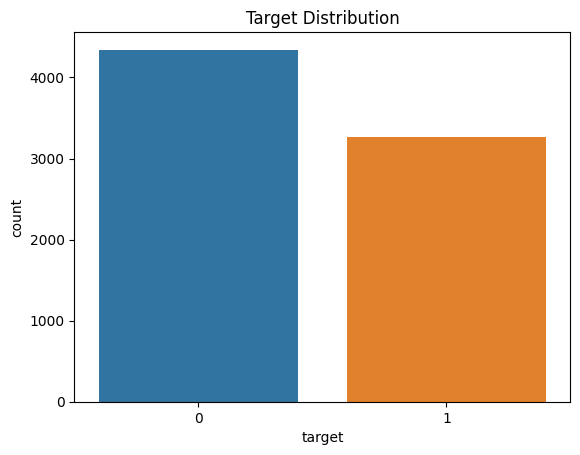

In [113]:
sns.countplot(data=train_data, x='target')
plt.title('Target Distribution')

In [114]:
train_data['target'].value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

The target seems fairly well balanced for this datset.

Some of the keywords include a %20 which should be a space. Let's replace it.

In [115]:
list(train_data['keyword'].unique())

['None',
 'ablaze',
 'accident',
 'aftershock',
 'airplane%20accident',
 'ambulance',
 'annihilated',
 'annihilation',
 'apocalypse',
 'armageddon',
 'army',
 'arson',
 'arsonist',
 'attack',
 'attacked',
 'avalanche',
 'battle',
 'bioterror',
 'bioterrorism',
 'blaze',
 'blazing',
 'bleeding',
 'blew%20up',
 'blight',
 'blizzard',
 'blood',
 'bloody',
 'blown%20up',
 'body%20bag',
 'body%20bagging',
 'body%20bags',
 'bomb',
 'bombed',
 'bombing',
 'bridge%20collapse',
 'buildings%20burning',
 'buildings%20on%20fire',
 'burned',
 'burning',
 'burning%20buildings',
 'bush%20fires',
 'casualties',
 'casualty',
 'catastrophe',
 'catastrophic',
 'chemical%20emergency',
 'cliff%20fall',
 'collapse',
 'collapsed',
 'collide',
 'collided',
 'collision',
 'crash',
 'crashed',
 'crush',
 'crushed',
 'curfew',
 'cyclone',
 'damage',
 'danger',
 'dead',
 'death',
 'deaths',
 'debris',
 'deluge',
 'deluged',
 'demolish',
 'demolished',
 'demolition',
 'derail',
 'derailed',
 'derailment',
 'desola

In [116]:
train_data['keyword'] = train_data['keyword'].str.replace('%20', ' ')

Check for duplicates.

In [118]:
train_data.duplicated().sum()

72

In [119]:
train_data.drop_duplicates(inplace=True)

In [127]:
train_data.duplicated().sum()

0

Let's clean the tweets to get rid of symbols and URLs.

In [130]:
from cleantext.sklearn import CleanTransformer

In [132]:
cleaner = CleanTransformer(no_urls=True, no_emails=True,
                           no_currency_symbols=True, no_punct=True, lang='en')

In [135]:
train_data['text'] = cleaner.transform(train_data['text'])

In [138]:
train_data['text']

id
1        our deeds are the reason of this earthquake ma...
4                    forest fire near la ronge sask canada
5        all residents asked to shelter in place are be...
6        13000 people receive wildfires evacuation orde...
7        just got sent this photo from ruby alaska as s...
                               ...                        
10869    two giant cranes holding a bridge collapse int...
10870    ariaahrary thetawniest the out of control wild...
10871           m194 0104 utc5km s of volcano hawaii <url>
10872    police investigating after an ebike collided w...
10873    the latest more homes razed by northern califo...
Name: text, Length: 7541, dtype: object

## Vectorize the Text and Keyword Columns